In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names_text = open("names.txt", "r").read()
words = names_text.splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
chars = ['.'] + sorted(list(set("".join(words)) - set(['.'])))
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for i, c in enumerate(chars)}
VOCABULARY_SIZE = len(chars)
VOCABULARY_SIZE

27

In [5]:
CONTEXT_LENGTH = 3
X, Y = [], []
for word in words:
    # print(word)
    context = [0] * CONTEXT_LENGTH
    for c in word:
        idx = ctoi[c]
        X.append(context)
        Y.append(idx)
        # print("".join(itoc[i] for i in context), "----->", itoc[idx])
        context = context[1:] + [idx]


# X is a list of contexts and Y is a associated list of characters that follow the context
# for example:
# "abc" -> "d" is represented as [0, 1, 2] -> 3
# where [0, 1, 2] \in X and 3 \in Y
X, Y = torch.tensor(X), torch.tensor(Y)
X.shape

torch.Size([196113, 3])

In [6]:
EMBEDDING_DIMS = 2
C = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMS)) # embeddding matrix
C

tensor([[-1.1164, -0.5164],
        [ 0.0722,  0.0232],
        [ 0.9174,  1.1120],
        [-1.4235,  0.5143],
        [ 0.4937,  1.3675],
        [-0.1749, -0.0838],
        [ 0.0614, -1.5793],
        [ 0.1766, -1.1690],
        [-0.4535, -0.7382],
        [ 0.3714, -1.9877],
        [ 0.1047,  0.3011],
        [ 0.0942, -0.6268],
        [-0.5751,  0.4746],
        [ 1.1451,  0.2695],
        [-0.4930, -2.5167],
        [ 1.0447,  0.5471],
        [ 1.4879, -1.4767],
        [ 0.5205, -0.0673],
        [ 0.9143,  0.7341],
        [-0.8811,  0.1741],
        [ 0.9351, -0.1631],
        [-1.2363, -1.8751],
        [-1.5996,  0.7975],
        [-0.3029,  1.1794],
        [ 1.1434,  1.3323],
        [-2.1338, -0.0730],
        [-1.1322, -0.9324]])

In [7]:
# How to embedd letter 'c'?
idx = ctoi['c']
C[idx]

tensor([-1.4235,  0.5143])

In [8]:
# How to embedd context 'abc'?
context = [0, 1, 2]
C[[context]]

tensor([[-1.1164, -0.5164],
        [ 0.0722,  0.0232],
        [ 0.9174,  1.1120]])

In [9]:
# How to embedd context 'abc' and 'bcd' simultaneously?
contexts = torch.tensor([[0, 1, 2], [1, 2, 3]])
C[contexts]

tensor([[[-1.1164, -0.5164],
         [ 0.0722,  0.0232],
         [ 0.9174,  1.1120]],

        [[ 0.0722,  0.0232],
         [ 0.9174,  1.1120],
         [-1.4235,  0.5143]]])

In [10]:
# How to embedd all contexts?
embedding = C[X]
embedding.shape

torch.Size([196113, 3, 2])

In [11]:
# Concat all embeddings within a context
embedding = embedding.reshape(len(X), EMBEDDING_DIMS * CONTEXT_LENGTH)
embedding.shape

torch.Size([196113, 6])

In [ ]:
VOCABULARY_SIZE = len(chars)
EMBEDDING_DIMS = 2
CONTEXT_LENGTH = 3
HIDDEN_LAYER = 100

class MLP():
    def __init__(self):
        self.C = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMS), requires_grad=True)

        self.W1 = torch.randn((EMBEDDING_DIMS * CONTEXT_LENGTH, HIDDEN_LAYER), requires_grad=True)
        self.b1 = torch.randn((HIDDEN_LAYER), requires_grad=True)

        self.W2 = torch.randn(HIDDEN_LAYER, VOCABULARY_SIZE, requires_grad=True)
        self.b2 = torch.randn(VOCABULARY_SIZE, requires_grad=True)

        self.loss = None

    def forward(self, X: torch.tensor) -> torch.tensor:
        X = F.tanh(X @ self.W1 + self.b1)
        X = X @ self.W2 + self.b2
        return X

    def calculate_loss(self, X: torch.tensor, Y: torch.tensor) -> torch.tensor:
        self.loss = F.cross_entropy(X, Y)
        return self.loss

    def backward(self):
        self.W1.grad = None
        self.b1.grad = None
        self.W2.grad = None
        self.b2.grad = None
        self.C.grad = None
        self.loss.backward()

    def update(self, lr: float):
        self.W1.data -= self.W1.grad * lr 
        self.b1.data -= self.b1.grad * lr
        self.W2.data -= self.W2.grad * lr
        self.b2.data -= self.b2.grad * lr
        self.C.data -= self.C.grad * lr

    def train(self, X: torch.tensor, Y: torch.tensor, epochs: int, lr: float, batch_size: int):
        for epoch in range(epochs):
            # select mini-batch
            batch_idx = torch.randint(0, len(X), (batch_size,))
            X_train = X[batch_idx]
            y_train = Y[batch_idx]

            embedded = self.embedd(X_train)
            logits = self.forward(embedded)
            self.calculate_loss(logits, y_train)
            self.backward()
            self.update(lr)
            # print(f"{epoch=}, loss={self.loss.item()}")

    def embedd(self, X: torch.tensor) -> torch.tensor:
        X = self.C[X]
        return X.view(-1, EMBEDDING_DIMS * CONTEXT_LENGTH)

    def predict(self, text: str) -> str:
        context = torch.tensor([ctoi[c] for c in text[:CONTEXT_LENGTH]])
        embedd = self.embedd(context)
        logits = self.forward(embedd)
        # select stochasticaly
        idx = torch.multinomial(F.softmax(logits, dim=1), 1).item()
        return text + itoc[idx]
    
    def evaluate(self, X: torch.tensor, Y: torch.tensor) -> float:
        embedded = self.embedd(X)
        logits = self.forward(embedded)
        return F.cross_entropy(logits, Y).item()

In [141]:
# Evaluate the model on entire dataset
mlp = MLP()
mlp.train(X, Y, epochs=100, lr=1, batch_size=32)
mlp.evaluate(X, Y)

8.951860427856445

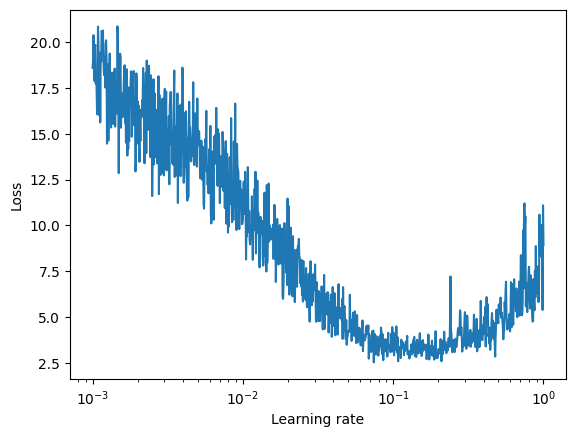

In [142]:
# Determine the reasonable learning rate
mlp = MLP()
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

losses = []
lri = []

for lr in lrs:
    mlp.train(X, Y, epochs=1, lr=lr, batch_size=32)
    losses.append(mlp.loss.item())
    lri.append(lr)

plt.plot(lri, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.xscale('log')
plt.show()

In [143]:
# Seems like the learning rate 0.1 is reasonable
mlp = MLP()
mlp.train(X, Y, epochs=100000, lr=0.1, batch_size=32)

In [144]:
mlp.evaluate(X, Y)

2.454648017883301

In [153]:
# Let's do lerning rate decay
mlp.train(X, Y, epochs=10000, lr=0.001, batch_size=32)

In [ ]:
# Much better than our bigram model!
mlp.evaluate(X, Y)

2.295415163040161